## PROPHET

In [315]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

#### Declare some visual functions

In [316]:
def plot_actual_vs_predicted(X_validation, y_actual, y_pred, feature, xlabel, ylabel):
    """
    Draw a scatter plot comparing actual and predicted values for a specific feature.

    Parameters:
    X_validation (pd.DataFrame): Input data containing the feature to be plotted.
    y_actual (array-like): Actual value.
    y_pred (array-like): Predicted value.
    feature (str): Column name in X_validation to compare.
    xlabel (str): Label for the X-axis (name of the feature displayed on the chart).
    ylabel (str): Label for the Y-axis (e.g. Price, Area, ...).
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(X_validation[feature], y_actual, c='r', marker='o', label="Actual values", alpha=0.5) 
    plt.scatter(X_validation[feature], y_pred, c='b', marker='s', label="Predicted values", alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(f"Scatter Plot of Actual vs Predicted {ylabel} per {xlabel}")
    plt.show()


#### Select feature

##### Read data

- Practice training

In [317]:
df = pd.read_csv("TransformedData.csv")
df.head()

,Posted Time,District Name,Price per m2
0,2024-12-01,Huyện Hòa Vang,-1.113889
1,2024-12-02,Huyện Hòa Vang,-1.113889
2,2024-12-03,Huyện Hòa Vang,-1.113889
3,2024-12-04,Huyện Hòa Vang,-1.113889
4,2024-12-05,Huyện Hòa Vang,-1.116670


##### Input variables

- Practice training

In [318]:
# Bước 3: Chuẩn bị dữ liệu
# Chuyển đổi cột ngày thành định dạng datetime nếu chưa có
if not pd.api.types.is_datetime64_any_dtype(df['Posted Time']):
    df['Posted Time'] = pd.to_datetime(df['Posted Time'])

# Xem các quận/huyện có trong dữ liệu
districts = df['District Name'].unique()
print(f"Các quận/huyện trong dữ liệu: {districts}")

Các quận/huyện trong dữ liệu: ['Huyện Hòa Vang' 'Quận Cẩm Lệ' 'Quận Hải Châu' 'Quận Liên Chiểu'
 'Quận Ngũ Hành Sơn' 'Quận Sơn Trà' 'Quận Thanh Khê']


In [319]:
# Bước 4: Chia dữ liệu thành tập huấn luyện và tập kiểm tra cho từng quận
def split_train_test(data, test_size=0.1):
    # Dictionary lưu trữ dữ liệu đã chia của các quận
    district_data = {}
    
    for district in districts:
        # Lọc dữ liệu cho quận cụ thể
        district_df = data[data['District Name'] == district].copy()
        
        # Sắp xếp dữ liệu theo thời gian
        district_df = district_df.sort_values('Posted Time')
        
        # Chia dữ liệu thành tập train và test
        train_size = int(len(district_df) * (1 - test_size))
        train_df = district_df.iloc[:train_size]
        test_df = district_df.iloc[train_size:]
        
        # Chuyển đổi sang định dạng Prophet yêu cầu
        train_prophet = train_df[['Posted Time', 'Price per m2']].rename(
            columns={'Posted Time': 'ds', 'Price per m2': 'y'})
        
        test_prophet = test_df[['Posted Time', 'Price per m2']].rename(
            columns={'Posted Time': 'ds', 'Price per m2': 'y'})
        
        # Lưu vào dictionary
        district_data[district] = {
            'train_raw': train_df,
            'test_raw': test_df,
            'train_prophet': train_prophet,
            'test_prophet': test_prophet
        }
    
    return district_data

In [320]:
# Bước 5: Thực hiện chia dữ liệu
district_datasets = split_train_test(df, test_size=0.1)

In [321]:
# Bước 6: Hàm huấn luyện mô hình Prophet cho từng quận
def train_prophet_models(district_datasets):
    models = {}
    
    for district, datasets in district_datasets.items():
        print(f"Đang huấn luyện mô hình cho {district}...")
        
        # Lấy dữ liệu huấn luyện
        train_data = datasets['train_prophet']
        
        # Khởi tạo và huấn luyện mô hình
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.05  # Có thể điều chỉnh để kiểm soát độ mềm dẻo của xu hướng
        )
        
        model.fit(train_data)
        models[district] = model
    
    return models

In [322]:
# Bước 7: Huấn luyện mô hình
district_models = train_prophet_models(district_datasets)

Đang huấn luyện mô hình cho Huyện Hòa Vang...


11:39:44 - cmdstanpy - INFO - Chain [1] start processing


11:39:44 - cmdstanpy - INFO - Chain [1] done processing
11:39:44 - cmdstanpy - INFO - Chain [1] start processing
11:39:44 - cmdstanpy - INFO - Chain [1] done processing


Đang huấn luyện mô hình cho Quận Cẩm Lệ...
Đang huấn luyện mô hình cho Quận Hải Châu...


11:39:44 - cmdstanpy - INFO - Chain [1] start processing
11:39:44 - cmdstanpy - INFO - Chain [1] done processing
11:39:45 - cmdstanpy - INFO - Chain [1] start processing
11:39:45 - cmdstanpy - INFO - Chain [1] done processing


Đang huấn luyện mô hình cho Quận Liên Chiểu...
Đang huấn luyện mô hình cho Quận Ngũ Hành Sơn...


11:39:45 - cmdstanpy - INFO - Chain [1] start processing
11:39:45 - cmdstanpy - INFO - Chain [1] done processing
11:39:45 - cmdstanpy - INFO - Chain [1] start processing
11:39:45 - cmdstanpy - INFO - Chain [1] done processing


Đang huấn luyện mô hình cho Quận Sơn Trà...
Đang huấn luyện mô hình cho Quận Thanh Khê...


11:39:45 - cmdstanpy - INFO - Chain [1] start processing
11:39:45 - cmdstanpy - INFO - Chain [1] done processing


##### Target variables

- Practice training

In [323]:
def evaluate_model(district, model, datasets, forecast_periods=180):
    train_data = datasets['train_prophet']
    test_data = datasets['test_prophet']
    
    last_train_date = train_data['ds'].max()
    future = model.make_future_dataframe(periods=forecast_periods)
    forecast = model.predict(future)
    
    if not test_data.empty:
        test_dates = test_data['ds'].tolist()
        test_forecasts = forecast[forecast['ds'].isin(test_dates)]

        test_actual = test_data['y'].values
        test_predicted = test_forecasts['yhat'].values
        
        mae = np.mean(np.abs(test_actual - test_predicted))
        mse = np.mean((test_actual - test_predicted) ** 2)
        rmse = np.sqrt(mse)
    else:
        mae = mse = rmse = r2 = np.nan
    
    return {
        'district': district,
        'forecast': forecast,
        'test_metrics': {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
        }
    }


##### Divide into 2 training sets and validation sets

In [324]:
# Bước 9: Thực hiện đánh giá và dự báo cho từng quận
evaluation_results = {}
for district, model in district_models.items():
    result = evaluate_model(district, model, district_datasets[district], forecast_periods=180)
    evaluation_results[district] = result

In [325]:
def plot_district_forecast(district, model, eval_result, datasets):
    """
    Vẽ biểu đồ dự báo giá cho một quận cụ thể
    
    Parameters:
    district (str): Tên quận
    model (Prophet): Mô hình đã huấn luyện
    eval_result (dict): Kết quả đánh giá
    datasets (dict): Dữ liệu train/test của quận
    """
    forecast = eval_result['forecast']
    train_data = datasets['train_prophet']
    test_data = datasets['test_prophet']
    
    # Vẽ biểu đồ
    plt.figure(figsize=(14, 8))
    
    # Vẽ đường dự báo và khoảng tin cậy
    plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Dự báo')
    plt.fill_between(
        forecast['ds'], 
        forecast['yhat_lower'], 
        forecast['yhat_upper'], 
        color='blue', 
        alpha=0.2, 
        label='Khoảng tin cậy 80%'
    )
    
    # Vẽ dữ liệu huấn luyện
    plt.scatter(train_data['ds'], train_data['y'], color='black', s=10, label='Dữ liệu huấn luyện')
    
    # Vẽ dữ liệu kiểm tra nếu có
    if not test_data.empty:
        plt.scatter(test_data['ds'], test_data['y'], color='red', s=10, label='Dữ liệu kiểm tra')
    
    # Thông tin về chỉ số đánh giá
    metrics = eval_result['test_metrics']
    r2 = metrics.get('r2', None)
    metrics_text = f"MAE: {metrics['mae']:.4f}, RMSE: {metrics['rmse']:.4f}"
    
    plt.title(f'Dự báo giá bất động sản tại {district}\n{metrics_text}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (đơn vị/m2)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Vẽ các thành phần của mô hình
    fig_comp = model.plot_components(forecast)
    
    return plt


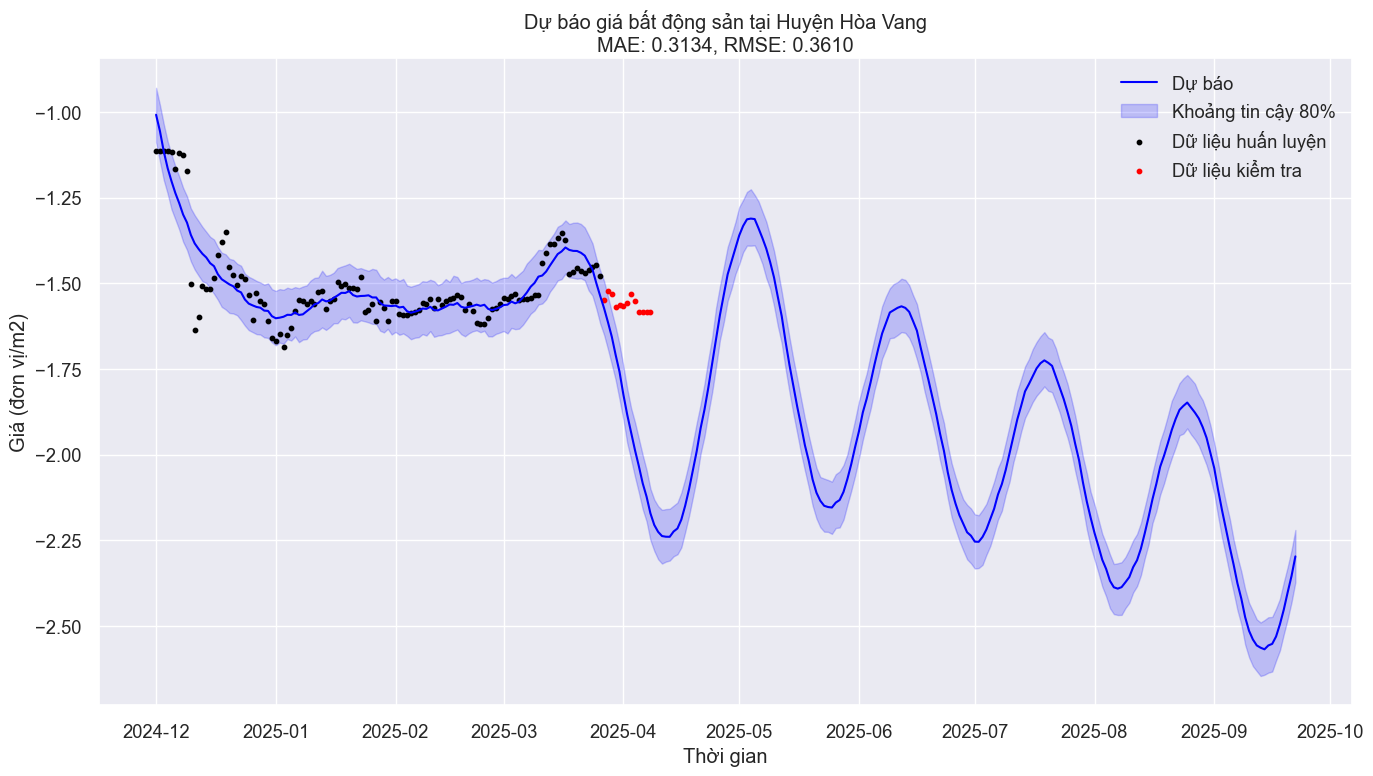

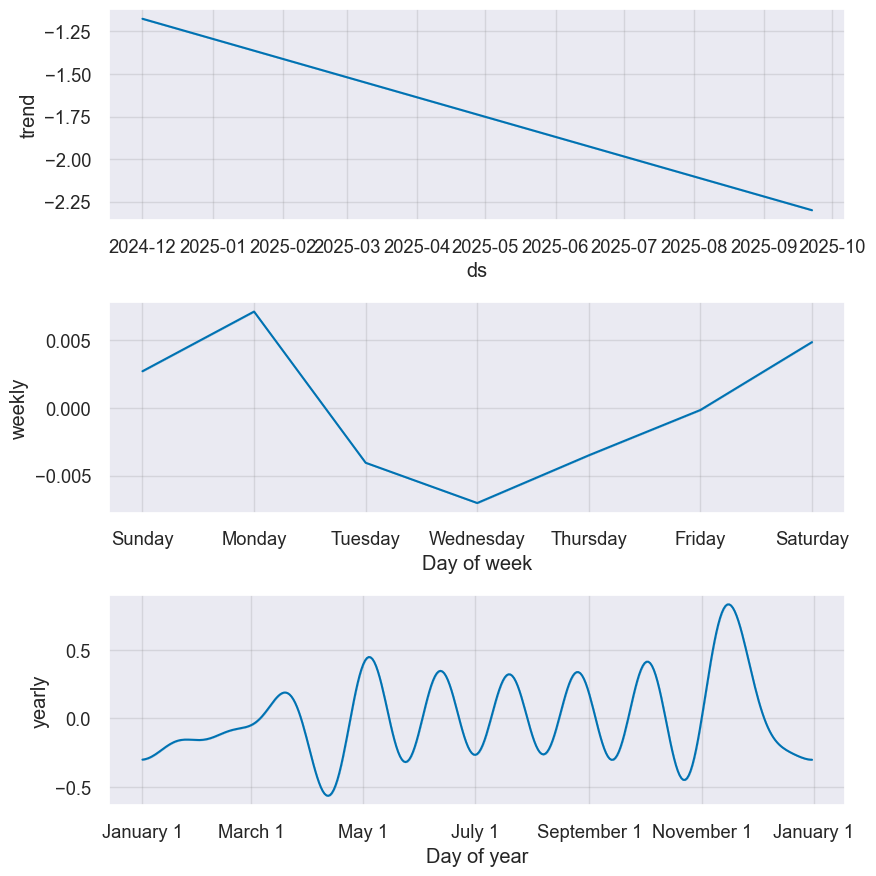

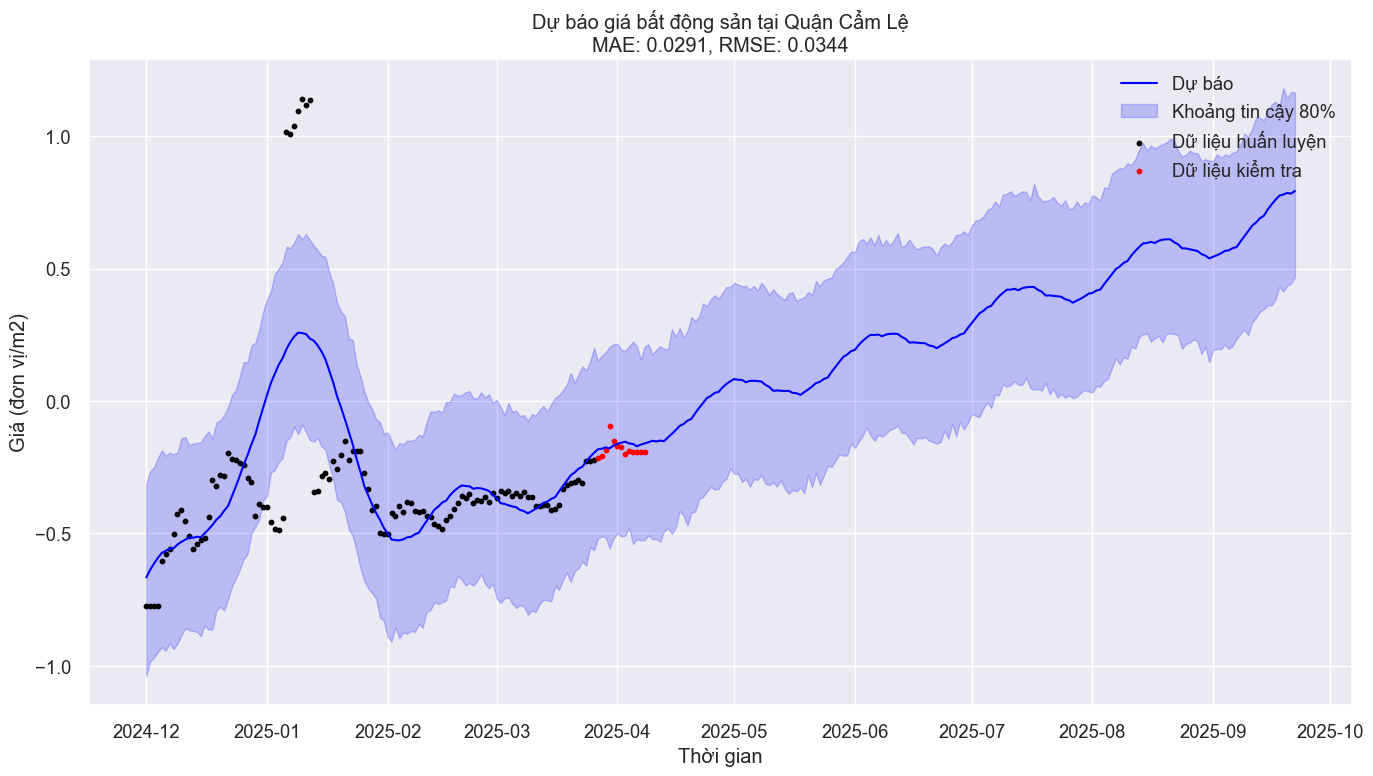

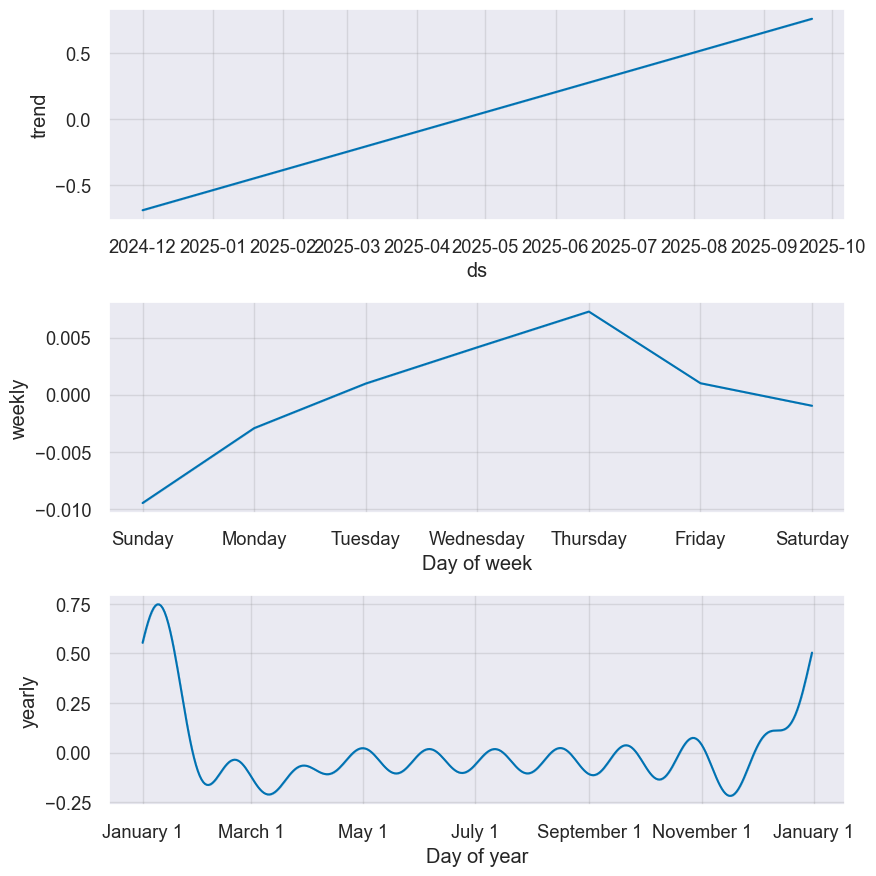

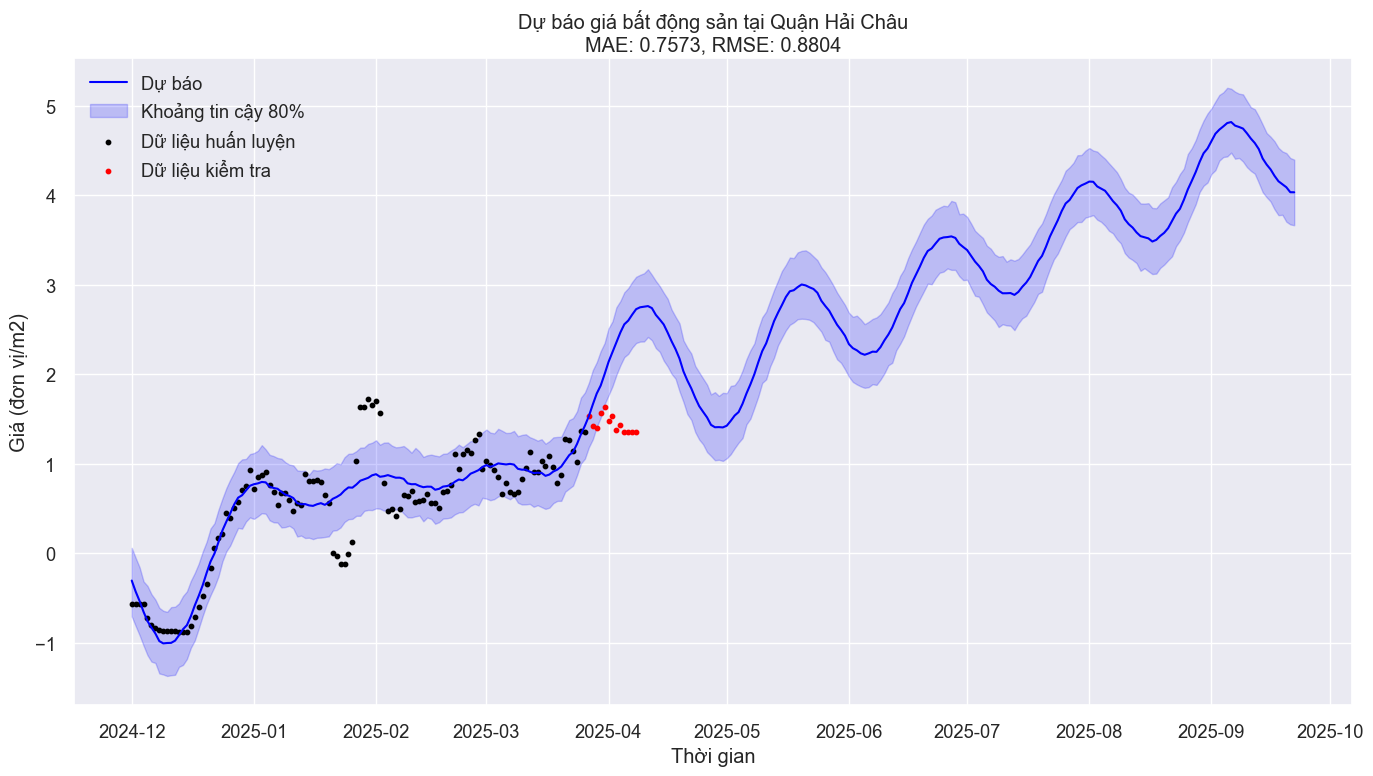

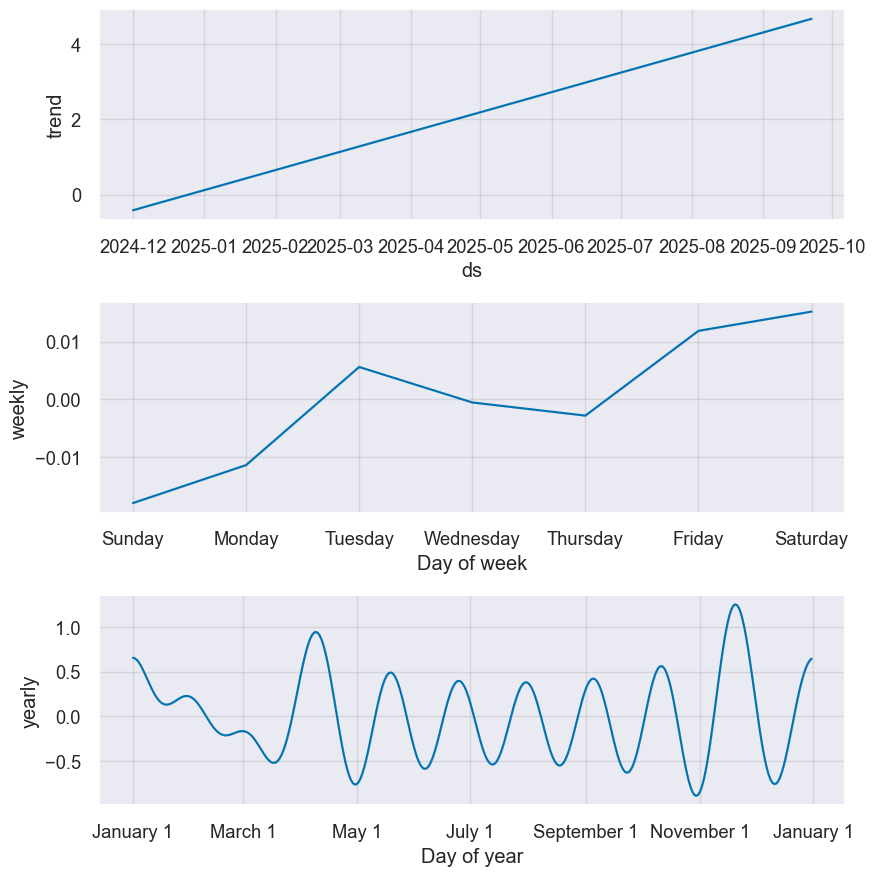

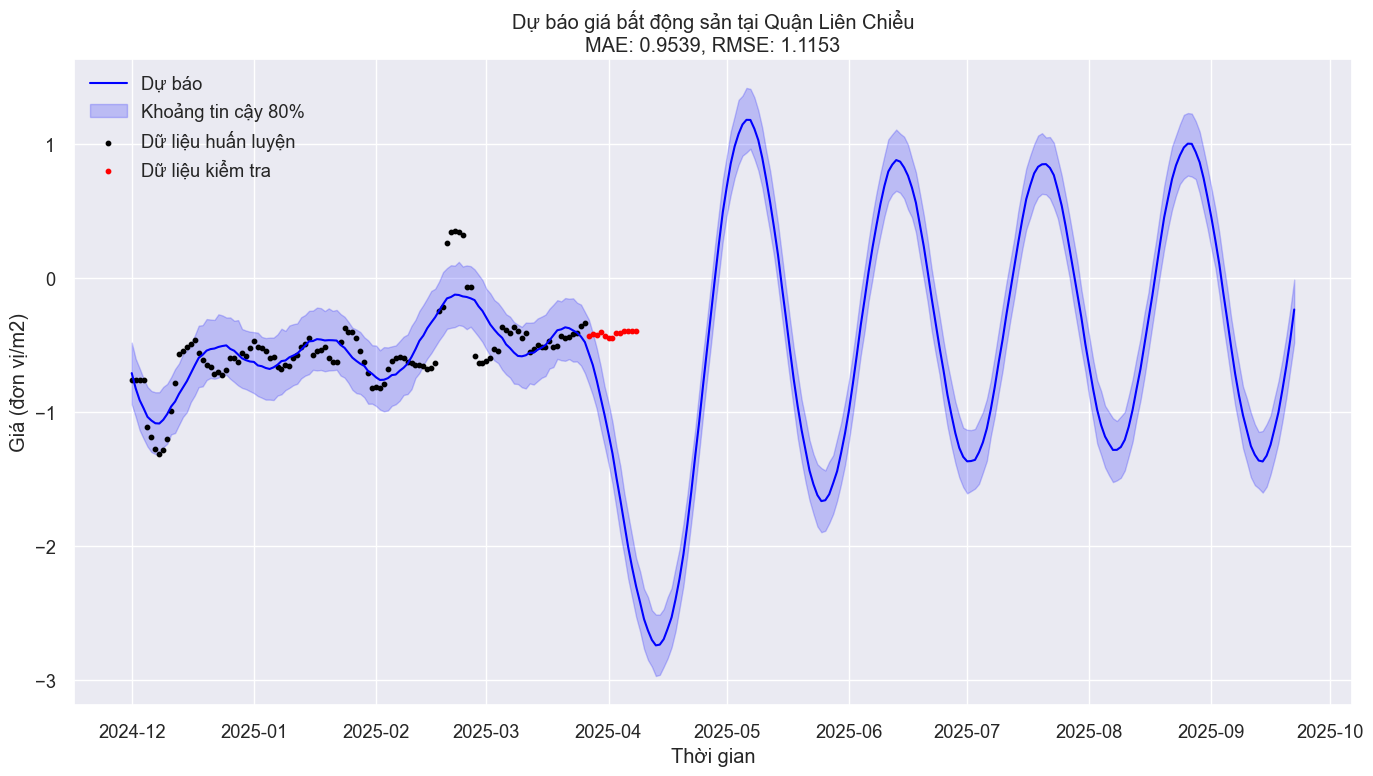

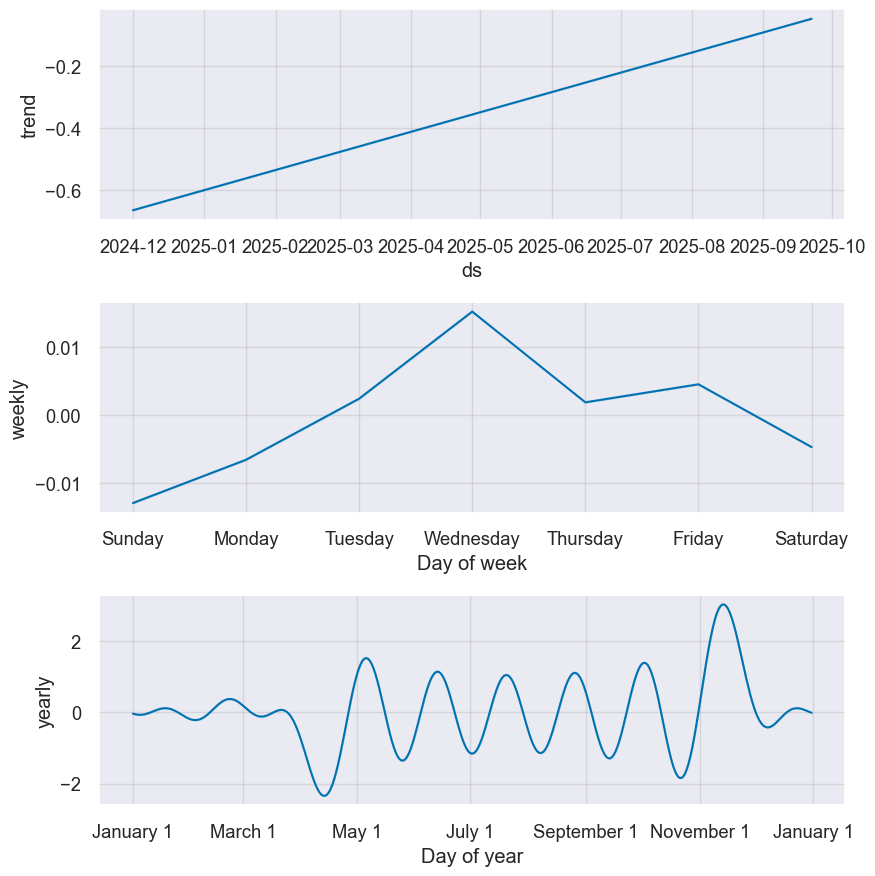

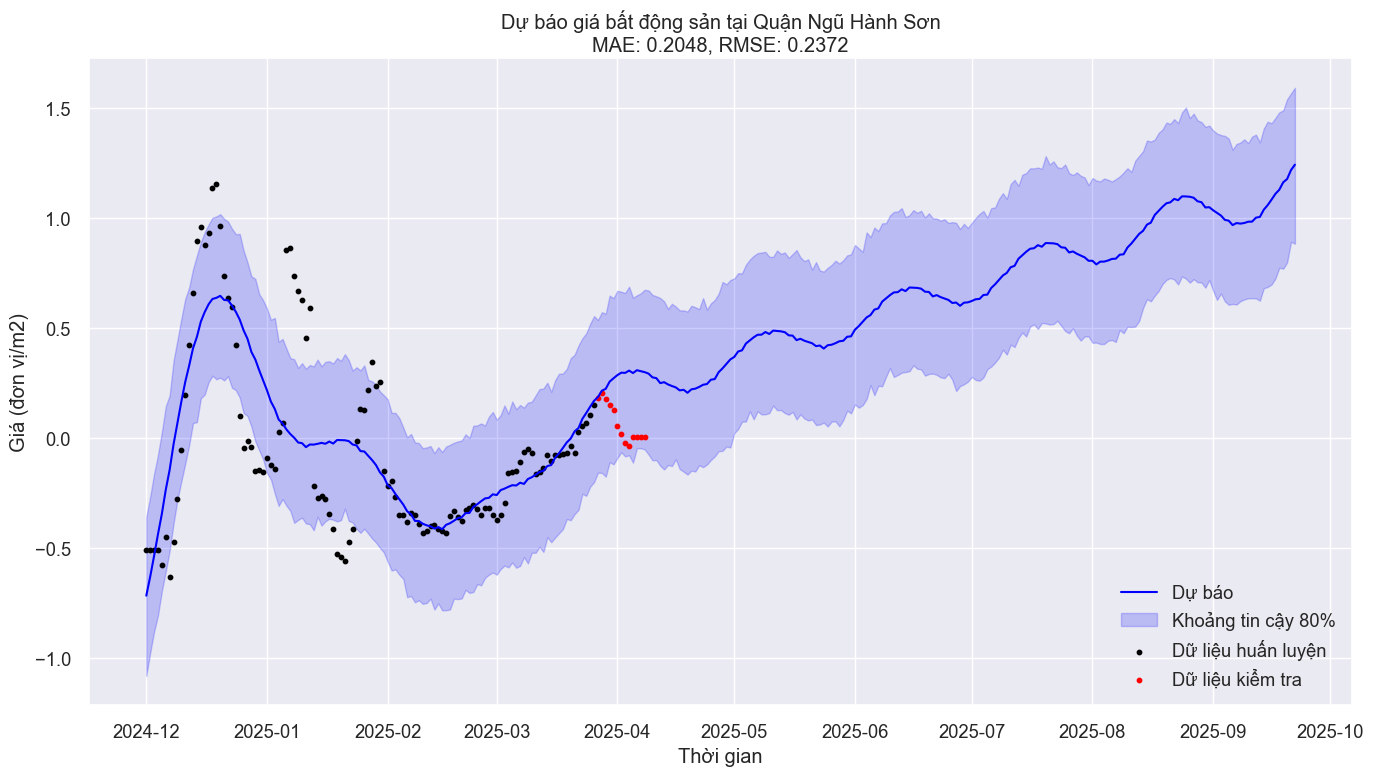

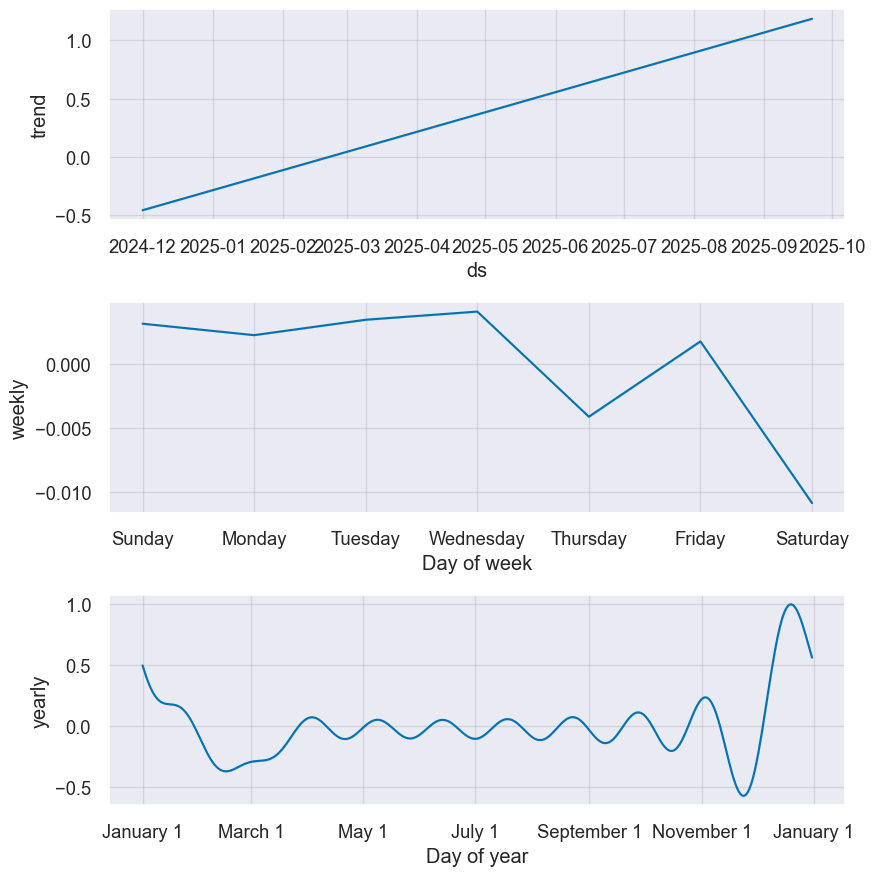

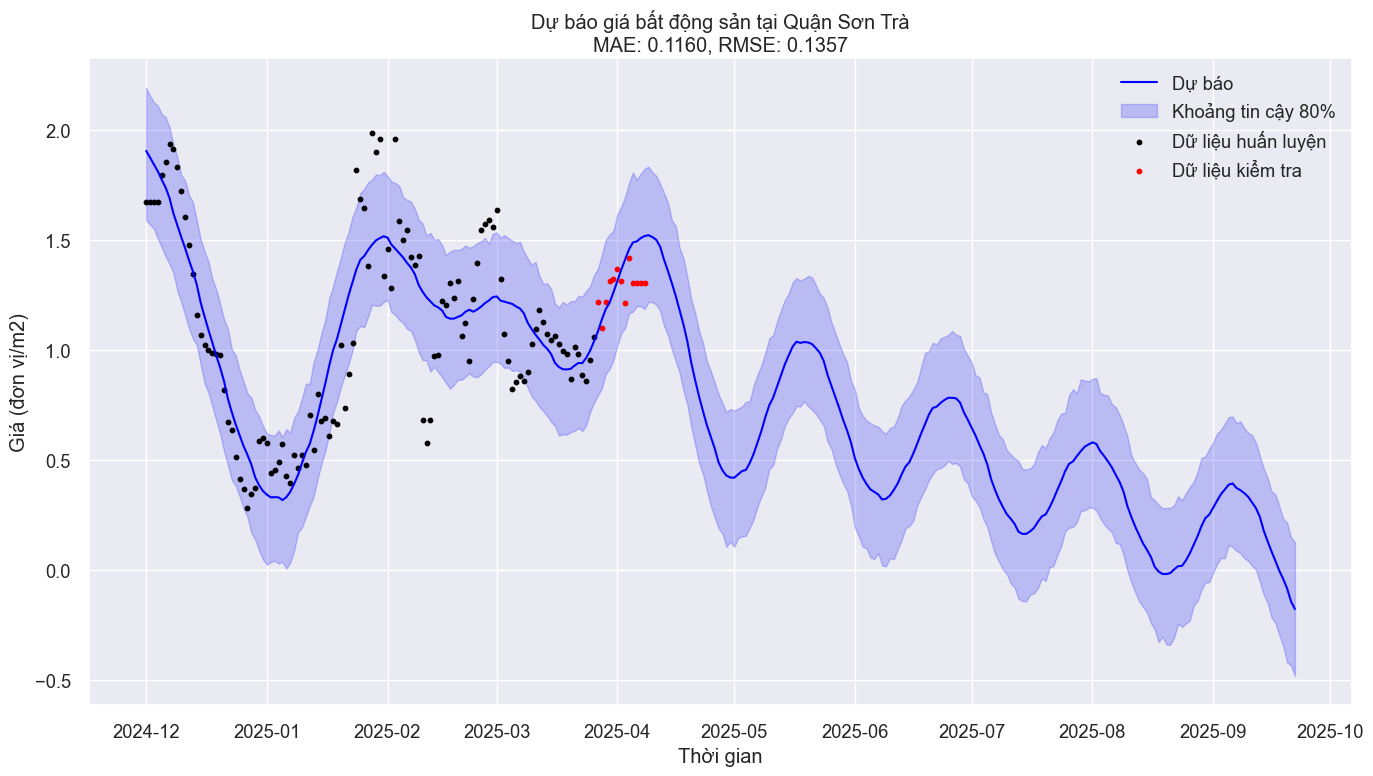

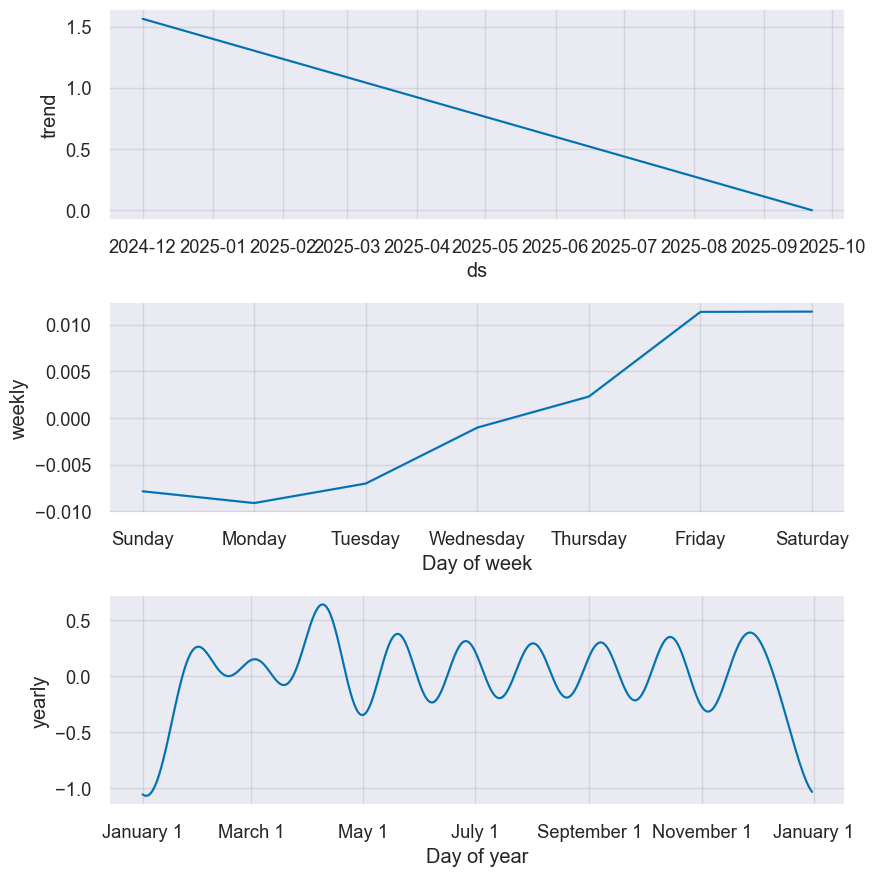

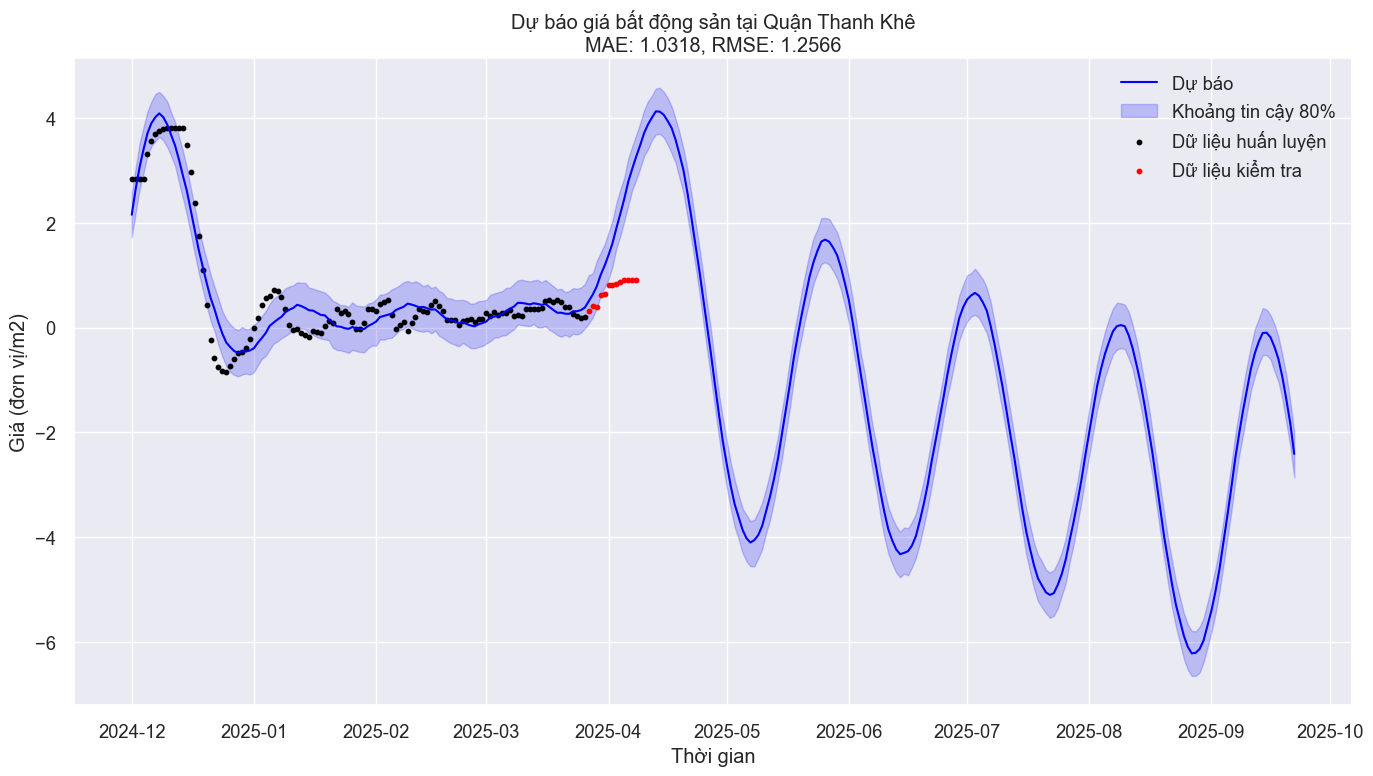

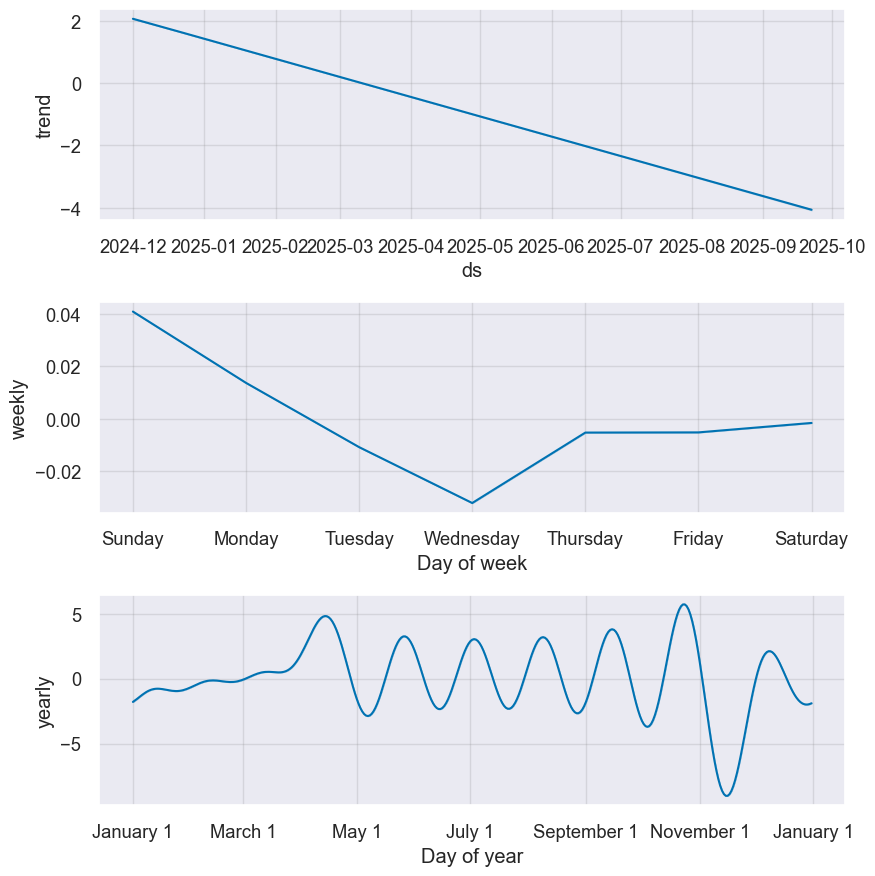

In [326]:
# Bước 11: Vẽ biểu đồ cho từng quận
for district in districts:
    plot_district_forecast(
        district,
        district_models[district],
        evaluation_results[district],
        district_datasets[district]
    ).show()

##### Real estate price prediction

- On the train set

In [327]:
# Bước 12: Dự báo giá trong một khoảng thời gian cho quận cụ thể
def forecast_district_range(district, model, start_date, end_date):
    """
    Dự báo giá cho một quận trong một khoảng thời gian cụ thể
    
    Parameters:
    district (str): Tên quận
    model (Prophet): Mô hình đã huấn luyện
    start_date (str): Ngày bắt đầu (định dạng 'YYYY-MM-DD')
    end_date (str): Ngày kết thúc (định dạng 'YYYY-MM-DD')
    
    Returns:
    DataFrame: Kết quả dự báo trong khoảng thời gian
    """
    # Chuyển đổi sang datetime
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Tạo dataframe các ngày cần dự báo
    dates = pd.date_range(start=start, end=end)
    future = pd.DataFrame({'ds': dates})
    
    # Dự báo
    forecast = model.predict(future)
    
    # Tạo dataframe kết quả đẹp hơn
    result_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(
        columns={
            'ds': 'Ngày', 
            'yhat': 'Giá dự báo', 
            'yhat_lower': 'Giá thấp nhất (80%)', 
            'yhat_upper': 'Giá cao nhất (80%)'
        }
    )
    
    return result_df

In [328]:
# Bước 13: Ứng dụng: Dự báo giá cho một quận cụ thể trong khoảng thời gian
selected_district = districts[0]  # Thay đổi theo quận bạn muốn dự báo
start_date = '2025-05-06'         # Thay đổi theo nhu cầu
end_date = '2025-06-06'           # Thay đổi theo nhu cầu

forecast_result = forecast_district_range(
    selected_district,
    district_models[selected_district],
    start_date,
    end_date
)

print(f"Dự báo giá cho {selected_district} từ {start_date} đến {end_date}:")
forecast_result.head(10)  # Hiển thị 10 ngày đầu tiên

Dự báo giá cho Huyện Hòa Vang từ 2025-05-06 đến 2025-06-06:


,Ngày,Giá dự báo,Giá thấp nhất (80%),Giá cao nhất (80%)
0,2025-05-06,-1.339614,-1.410156,-1.261722
1,2025-05-07,-1.368019,-1.442945,-1.287806
2,2025-05-08,-1.398887,-1.472082,-1.321403
3,2025-05-09,-1.438057,-1.518980,-1.360825
4,2025-05-10,-1.482652,-1.560532,-1.401740
5,2025-05-11,-1.540307,-1.620092,-1.458649
6,2025-05-12,-1.595950,-1.680863,-1.523843
7,2025-05-13,-1.670277,-1.744367,-1.591238
8,2025-05-14,-1.737995,-1.821596,-1.662683
9,2025-05-15,-1.799251,-1.882982,-1.719676


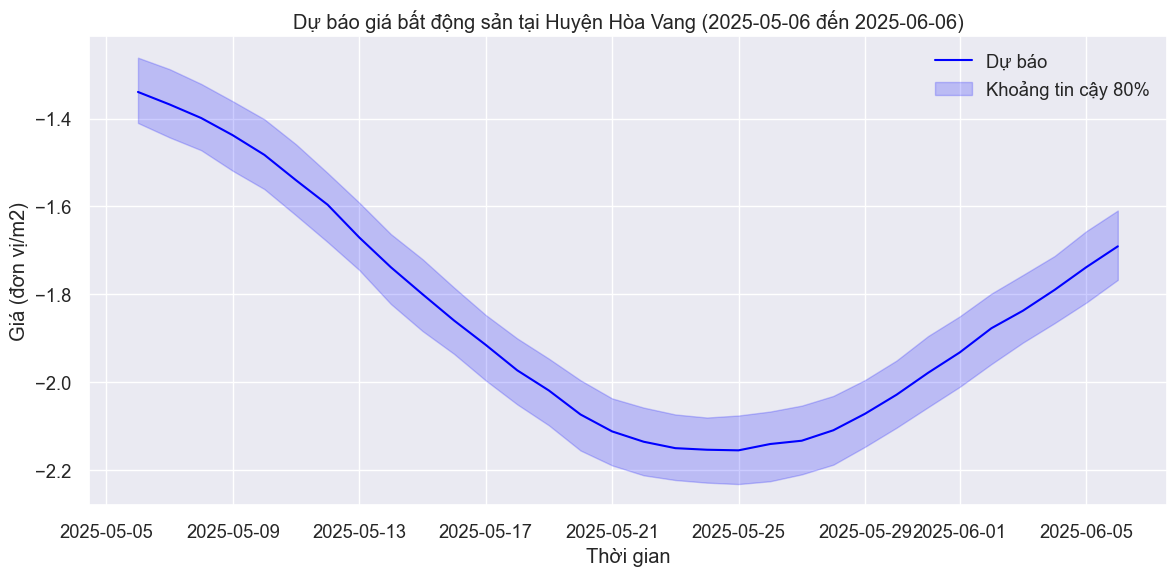

In [329]:
# Bước 14: Vẽ biểu đồ dự báo trong khoảng thời gian
plt.figure(figsize=(12, 6))
plt.plot(forecast_result['Ngày'], forecast_result['Giá dự báo'], color='blue', label='Dự báo')
plt.fill_between(
    forecast_result['Ngày'],
    forecast_result['Giá thấp nhất (80%)'],
    forecast_result['Giá cao nhất (80%)'],
    color='blue',
    alpha=0.2,
    label='Khoảng tin cậy 80%'
)

plt.title(f'Dự báo giá bất động sản tại {selected_district} ({start_date} đến {end_date})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đơn vị/m2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [330]:
# Bước 15: Tạo hàm dự báo cho tất cả các quận trong một khoảng thời gian
def forecast_all_districts(models, start_date, end_date):
    """
    Dự báo giá cho tất cả các quận trong một khoảng thời gian
    
    Parameters:
    models (dict): Dictionary chứa các mô hình đã huấn luyện
    start_date (str): Ngày bắt đầu (định dạng 'YYYY-MM-DD')
    end_date (str): Ngày kết thúc (định dạng 'YYYY-MM-DD')
    
    Returns:
    dict: Kết quả dự báo cho từng quận
    """
    results = {}
    
    for district, model in models.items():
        results[district] = forecast_district_range(
            district, model, start_date, end_date
        )
    
    return results

In [331]:
# Bước 16: Dự báo cho tất cả quận
all_forecasts = forecast_all_districts(district_models, start_date, end_date)

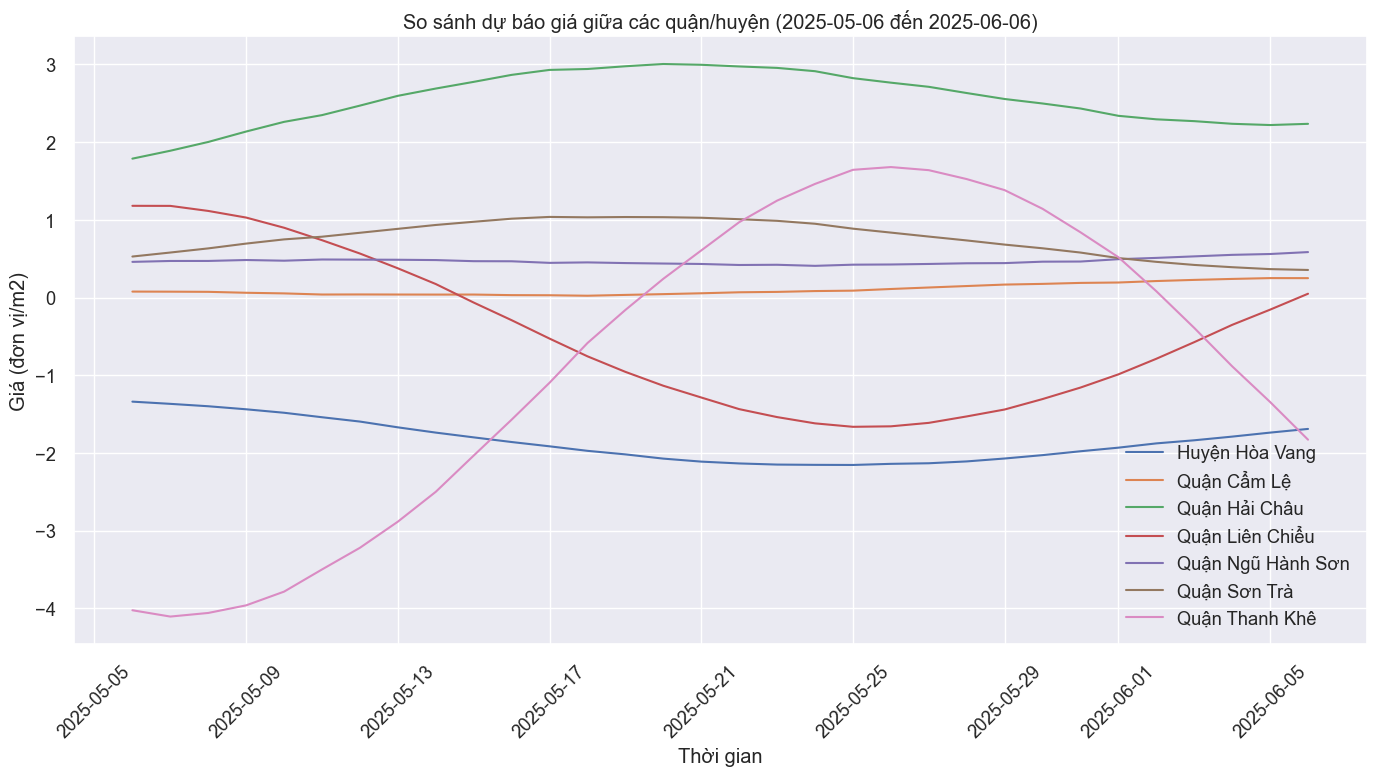

In [332]:
# Bước 17: So sánh dự báo giữa các quận (biểu đồ đường)
plt.figure(figsize=(14, 8))

for district, forecast_df in all_forecasts.items():
    plt.plot(forecast_df['Ngày'], forecast_df['Giá dự báo'], label=district)

plt.title(f'So sánh dự báo giá giữa các quận/huyện ({start_date} đến {end_date})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đơn vị/m2)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [333]:
# Bước 19: Lưu mô hình để sử dụng sau này (tùy chọn)
import pickle

# Lưu các mô hình
with open('district_prophet_models.pkl', 'wb') as f:
    pickle.dump(district_models, f)

print("Đã lưu mô hình thành công")

Đã lưu mô hình thành công


In [334]:
# Bước 20: Hàm tiện ích để dự báo nhanh trong tương lai
def quick_forecast(district, date, models):
    """
    Dự báo nhanh giá cho một quận vào một ngày cụ thể
    
    Parameters:
    district (str): Tên quận
    date (str): Ngày cần dự báo, định dạng 'YYYY-MM-DD'
    models (dict): Dictionary chứa các mô hình đã huấn luyện
    
    Returns:
    float: Giá dự báo
    """
    if district not in models:
        print(f"Không tìm thấy mô hình cho {district}")
        return None
    
    try:
        date_obj = pd.to_datetime(date)
        model = models[district]
        future = pd.DataFrame([{'ds': date_obj}])
        forecast = model.predict(future)
        
        return {
            'date': date,
            'district': district,
            'predicted_price': forecast['yhat'].values[0],
            'lower_bound': forecast['yhat_lower'].values[0],
            'upper_bound': forecast['yhat_upper'].values[0]
        }
    except Exception as e:
        print(f"Lỗi khi dự báo: {e}")
        return None

In [335]:
# Ví dụ sử dụng hàm dự báo nhanh
test_date = "2025-06-01"  # Thay đổi theo nhu cầu

print(f"Dự báo giá cho ngày {test_date}:")
for district in districts:
    result = quick_forecast(district, test_date, district_models)
    if result:
        print(f"{result['district']}: {result['predicted_price']:.2f} đơn vị/m2 " +
              f"(Khoảng tin cậy: {result['lower_bound']:.2f} - {result['upper_bound']:.2f})")

Dự báo giá cho ngày 2025-06-01:
Huyện Hòa Vang: -1.93 đơn vị/m2 (Khoảng tin cậy: -2.01 - -1.85)
Quận Cẩm Lệ: 0.19 đơn vị/m2 (Khoảng tin cậy: -0.16 - 0.58)
Quận Hải Châu: 2.34 đơn vị/m2 (Khoảng tin cậy: 1.97 - 2.73)
Quận Liên Chiểu: -0.99 đơn vị/m2 (Khoảng tin cậy: -1.21 - -0.75)
Quận Ngũ Hành Sơn: 0.49 đơn vị/m2 (Khoảng tin cậy: 0.11 - 0.86)
Quận Sơn Trà: 0.51 đơn vị/m2 (Khoảng tin cậy: 0.20 - 0.78)
Quận Thanh Khê: 0.52 đơn vị/m2 (Khoảng tin cậy: 0.03 - 0.96)
